In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import seaborn as sns
from scipy.stats import multivariate_normal
# import scienceplots
# plt.style.use('ieee')

In [2]:
def normalize(df, column_index):
    mean = df.iloc[:, column_index].mean()
    std = df.iloc[:, column_index].std()
    for i in range(len(df)):
        df.iloc[i, column_index] = (df.iloc[i, column_index] - mean)/std


In [3]:
df = pd.read_excel("../final_data/data360.xlsx")
df2 = pd.read_excel("../final_data/data2300.xlsx")

In [4]:
sorted_Etrials = sorted(df["Etrial"])
df.sort_values(by="Etrial", axis=0, inplace=True)
# freq_m = df["appear freq"].mean()
# freq_s = df["appear freq"].std()
# df["appear freq"] = (df["appear freq"] - freq_m)/freq_s
df["D_level"] = 0
# df.iloc[0:90, 18] = 0
# df.iloc[90:270, 18] = 1
# df.iloc[270:, 18] = 2

In [5]:
df1 = df.iloc[:, 4:17]

In [6]:
df2 = df2.sample(frac=1)


In [7]:
words = df2.word

In [8]:
df2.drop("word", axis=1, inplace=True)

In [9]:
df2.columns == df1.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [10]:
# def normalize(df, column_index):
#     mean = df.iloc[:, column_index].mean()
#     std = df.iloc[:, column_index].std()
#     for i in range(len(df)):
#         df.iloc[i, column_index] = (df.iloc[i, column_index] - mean)/std

# for i in range(11):
#     normalize(df2, i)

In [11]:
k = 3
beta = 1

df["D_level"] = 0
n_i = len(df)//k
for i in range(k):
    print(n_i*i, n_i*(i+1))
    df.iloc[n_i*i:(n_i*(i+1)), 17] = i
df.iloc[(n_i*(i+1)):, 17] = k-1

0 119
119 238
238 357


In [12]:
GMMs = [GaussianMixture(n_components=1) for i in range(k)]

for i in range(k):
    GMMs[i].fit(df1.loc[df["D_level"]==i, :])

e:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
e:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
e:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [13]:
pis = np.ones(k) / k
# mus = np.zeros((k, 13))
# sigmas = np.zeros((k, 13, 13))
mus = np.array([GMMs[i].means_[0] for i in  range(k)])
sigmas = np.array([GMMs[i].covariances_[0] for i in  range(k)])

In [14]:
n1 = len(df1)
n2 = len(df2)

In [15]:
gammas = [np.ones(n2) for i in range(k)]

In [16]:
pred_0 = np.zeros(len(df))

In [17]:
iter = 0
while True:
    print(iter)
    denom = np.zeros(n2)
    nums = np.zeros((k, n2))
    pis_copy = pis.copy()
    for i in range(k):
        denom += multivariate_normal.pdf(df2, mean=mus[i], cov=sigmas[i]) * pis[i]
        nums[i] = multivariate_normal.pdf(df2, mean=mus[i], cov=sigmas[i]) * pis[i]
    for i in range(k):
        gamma_i = nums[i]/denom
        gammas[i] = gamma_i
        # print(gamma_i)
    
    for i in range(k):
        pis[i] = ((1-beta) * np.sum(gammas[i]) + beta * 120)/((1-beta)*n2 + beta * n1)
        if sum(gammas[i] == 0):
            num = beta * np.sum(df1.loc[df["D_level"]==i, :], axis=0)
        else:
            num = (1-beta) * np.average(df2, axis=0, weights=gammas[i]) * len(df2) + beta * np.sum(df1.loc[df["D_level"]==i, :], axis=0)
        denom = (1-beta) * np.sum(gammas[i]) + beta * 120
        mus[i] = num/denom
        num = (1-beta) * (np.matrix(df2) - mus[i]).T @ np.diag(gammas[i]) @ (np.matrix(df2) - mus[i]) + beta * (np.matrix(df1) - mus[i]).T @ (np.matrix(df1) - mus[i])
        sigmas[i] = num/denom
    

    s = np.sum(np.array([multivariate_normal.pdf(df1, mean=mus[i], cov=sigmas[i]) for i in range(k)]), axis=0)
    pred1 = np.argmax(np.array([multivariate_normal.pdf(df1, mean=mus[i], cov=sigmas[i])/s for i in range(k)]), axis=0)

    if sum(pred1 != pred_0) == 0:
        break
    pred_0 = pred1

    # if np.linalg.norm(pis-pis_copy) <= 0.001:
    #     break
    iter += 1


0
1


In [21]:
mean = np.zeros(13)
for i in range(3):
    mean += mus[i] * pis[i]

In [22]:
diff_mean = np.zeros(13)
for i in range(3):
    diff_mean += np.abs(mus[i] - mean)* pis[i]

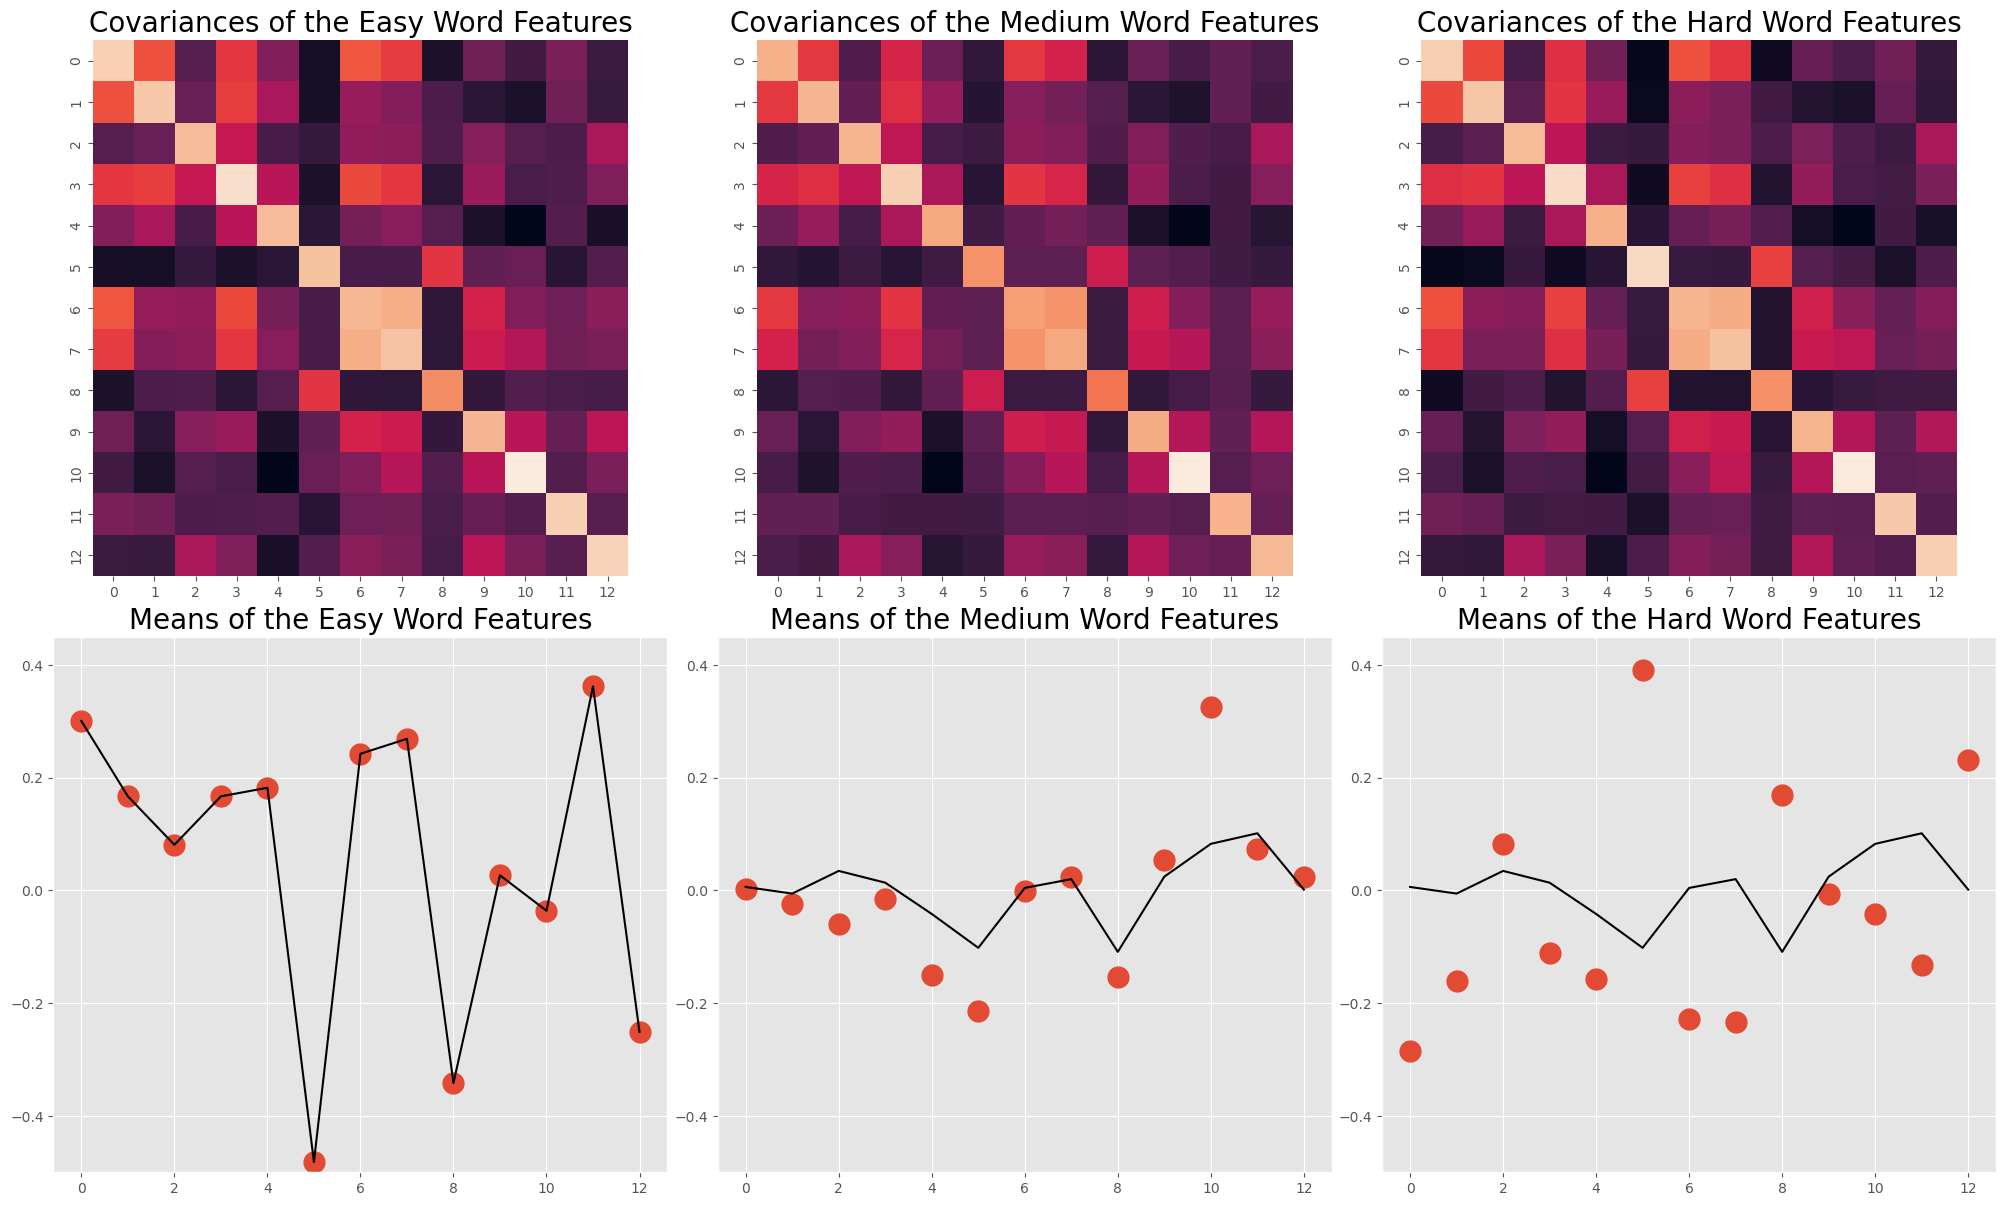

In [23]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(20, 12))

plt.subplot(2, 3, 1)
sns.heatmap(sigmas[0], square=True, cbar=False)
plt.title("Covariances of the Easy Word Features", fontsize=20)
# plt.imshow(sigmas[i])
plt.subplot(2, 3, 4)
plt.plot(range(13), mus[0], 'o', markersize=15)
plt.plot(range(13), mus[0], color="black")
plt.title("Means of the Easy Word Features", fontsize=20)
plt.ylim(-0.5, 0.45)
plt.subplot(2, 3, 2)
sns.heatmap(sigmas[1], square=True, cbar=False)
plt.title("Covariances of the Medium Word Features", fontsize=20)
# plt.imshow(sigmas[i])
plt.subplot(2, 3, 5)
plt.plot(range(13), mus[1], 'o', markersize=15)
plt.plot(range(13), mean, color="black")
plt.title("Means of the Medium Word Features", fontsize=20)
plt.ylim(-0.5, 0.45)
plt.subplot(2, 3, 3)
sns.heatmap(sigmas[2], square=True, cbar=False)
plt.title("Covariances of the Hard Word Features", fontsize=20)
# plt.imshow(sigmas[i])
plt.subplot(2, 3, 6)
plt.plot(range(13), mus[2], 'o', markersize=15)
plt.plot(range(13), mean, color="black")
plt.title("Means of the Hard Word Features", fontsize=20)
plt.ylim(-0.5, 0.45)
fig.tight_layout(pad=0.5)

In [24]:
df2.columns

Index(['double', 'trible', 'end', 'spaced double', 'begin', 'duplicate',
       'freq', 'freq weight', 'dupli conti', 'vowel num', 'begin vowel',
       'commonality', 'freq var'],
      dtype='object')

mean

In [43]:
s = np.sum(np.array([multivariate_normal.pdf(df1, mean=mus[i], cov=sigmas[i]) for i in range(k)]), axis=0)
pred = np.argmax(np.array([pis[i] * multivariate_normal.pdf(df1, mean=mus[i], cov=sigmas[i])/s for i in range(k)]), axis=0)

predicted_probs = np.zeros((k, n1))
for i in range(k):
    predicted_probs[i] = np.array(multivariate_normal.pdf(df1, mean=mus[i], cov=sigmas[i]))/s

In [44]:
predicted_probs.shape

(3, 359)

In [45]:
prediction = np.argmax(predicted_probs, axis=0)

In [ ]:
# predicted_probs = np.zeros((k, n2))
# for i in range(k):
#     predicted_probs[i] = np.array(multivariate_normal.pdf(df2, mean=mus[i], cov=sigmas[i]))/s


In [ ]:
# log_loss(df["D_level"], predicted_probs.T)

In [ ]:
# # k = 5 prediction transformation
# df.loc[df["D_level"]==2, "D_level"] = 1
# df.loc[df["D_level"]==3, "D_level"] = 1
# df.loc[df["D_level"]==4, "D_level"] = 2
# pred[pred==2] = 1
# pred[pred==3] = 1
# pred[pred==4] = 2

In [ ]:
# # k = 7 prediction transformation
# df.loc[df["D_level"]==1, "D_level"] = 0
# df.loc[df["D_level"]==2, "D_level"] = 1
# df.loc[df["D_level"]==3, "D_level"] = 1
# df.loc[df["D_level"]==4, "D_level"] = 1
# df.loc[df["D_level"]==5, "D_level"] = 2
# df.loc[df["D_level"]==6, "D_level"] = 2
# pred[pred==1] = 0
# pred[pred==2] = 1
# pred[pred==3] = 1
# pred[pred==4] = 1
# pred[pred==5] = 2
# pred[pred==6] = 2

In [ ]:
# # k = 9 prediction transformation
# df.loc[df["D_level"]==1, "D_level"] = 0
# df.loc[df["D_level"]==2, "D_level"] = 0
# df.loc[df["D_level"]==3, "D_level"] = 1
# df.loc[df["D_level"]==4, "D_level"] = 1
# df.loc[df["D_level"]==5, "D_level"] = 1
# df.loc[df["D_level"]==6, "D_level"] = 2
# df.loc[df["D_level"]==7, "D_level"] = 2
# df.loc[df["D_level"]==8, "D_level"] = 2
# pred[pred==1] = 0
# pred[pred==2] = 0
# pred[pred==3] = 1
# pred[pred==4] = 1
# pred[pred==5] = 1
# pred[pred==6] = 2
# pred[pred==7] = 2
# pred[pred==8] = 2

In [ ]:
# # k = 12 prediction transformation
# df.loc[df["D_level"]==1, "D_level"] = 0
# df.loc[df["D_level"]==2, "D_level"] = 0
# df.loc[df["D_level"]==3, "D_level"] = 0
# df.loc[df["D_level"]==4, "D_level"] = 1
# df.loc[df["D_level"]==5, "D_level"] = 1
# df.loc[df["D_level"]==6, "D_level"] = 1
# df.loc[df["D_level"]==7, "D_level"] = 1
# df.loc[df["D_level"]==8, "D_level"] = 2
# df.loc[df["D_level"]==9, "D_level"] = 2
# df.loc[df["D_level"]==10, "D_level"] = 2
# df.loc[df["D_level"]==11, "D_level"] = 2
# pred[pred==1] = 0
# pred[pred==2] = 0
# pred[pred==3] = 0
# pred[pred==4] = 1
# pred[pred==5] = 1
# pred[pred==6] = 1
# pred[pred==7] = 1
# pred[pred==8] = 2
# pred[pred==9] = 2
# pred[pred==10] = 2
# pred[pred==11] = 2

In [48]:
sum(pred == df["D_level"])/359

0.532033426183844

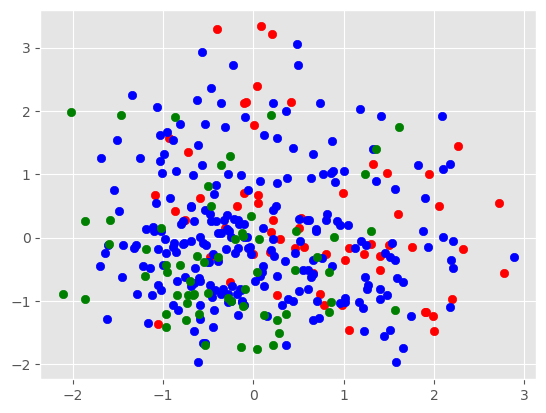

In [49]:
plt.scatter(df.loc[pred == 0, :]["commonality"], df.loc[pred == 0, :]["spaced double"], color="red")
plt.scatter(df.loc[pred == 1, :]["commonality"], df.loc[pred == 1, :]["spaced double"], color="blue")
plt.scatter(df.loc[pred == 2, :]["commonality"], df.loc[pred == 2, :]["spaced double"], color="green")